In [2]:
import tensorflow as tf
import math
import util
import numpy as np
import matplotlib.pyplot as plt
import sys
from IPython import display

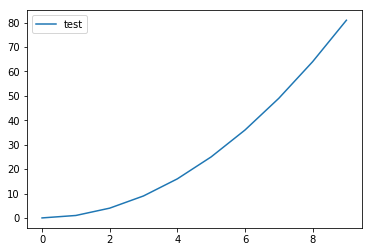

In [57]:
x = []
y = []
for i in range(10):
    x = np.append(x, i)
    y = np.append(y, i**2)
    plt.gca().cla() 
    plt.plot(x,y,label='test')
    plt.legend()
    display.clear_output(wait=True)
    if i != 9: display.display(plt.gcf()) 
    time.sleep(0.5) 
#plt.gca().cla() 

# Data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X = mnist.train._images.reshape(55000,784)
Y = mnist.train._labels
index = np.arange(55000)
np.random.seed(1)
np.random.shuffle(index)

train_unlabeled = util.BatchFeeder(X[index[:53000]], np.zeros(53000), 256)
train_labeled = util.BatchFeeder(X[index[53000:54000]], np.argmax(Y[index[53000:54000]], axis=1), 128)
test_labeled = (X[index[54000:]], np.argmax(Y[index[54000:]], axis=1))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


[ 0.]


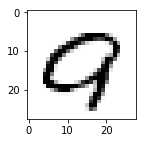

In [4]:
x, y = train_unlabeled.next()
print y[0]
plt.figure(figsize=(2,2))
plt.imshow(x[0].reshape((28,28)), cmap='Greys')
plt.show()

# Model

In [115]:
# Adapted from M2

class SSVAERegressor():
    def __init__(self):
        # Reset all existing tensors
        tf.reset_default_graph()
        
        # Tracking data
        self.loss = {"loss_l":[],
                    "rec_l":[],
                    "kld_l":[],
                    "err_l":[],
                    "loss_ul":[],
                    "rec_ul":[],
                    "kld_ul":[],
                    "ent_ul":[],
                    "mse":[]}
        self.record = {}
        
        # Define some parameters
        self.e = 0
        self.verbose = False
        
        # Define dimensionality
        self.input_dim = 784
        self.dims = [128, 64]
        self.latent_dim = 10
        self.prediction_dim = 1
        self.alpha = 0.1
        
        # Building the graph
        self.built = False
        self.sesh = tf.Session()
        self.ops = self.build()
        self.sesh.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter('logs', self.sesh.graph)
        
    def build(self):
        # Placeholders for input and dropout probs.
        if self.built:
            return -1
        else:
            self.built = True
            
        #####################
        # Building networks #
        #####################
        
        # Defining inputs
        x_in_labeled = tf.placeholder(tf.float32, shape=[None, self.input_dim], name="x_in_labeled")
        x_in_unlabeled = tf.placeholder(tf.float32, shape=[None, self.input_dim], name="x_in_unlabeled")
        y = tf.placeholder(tf.float32, shape=[None, self.prediction_dim], name="y")
            
        # Building network q(z|x)
        z_mu_labeled, z_log_sigma_labeled = self.encoder(x_in_labeled,
                                                         output_dim=self.latent_dim,
                                                         _is_train=True,
                                                         scope="encoder")
        z_mu_unlabeled, z_log_sigma_unlabeled = self.encoder(x_in_unlabeled,
                                                             output_dim=self.latent_dim,
                                                             _is_train=True,
                                                             scope="encoder", 
                                                             reuse=True)
        
        # Building network q(y|x)
        y_mu_labeled, y_log_sigma_labeled = self.encoder(x_in_labeled,
                                                         output_dim=self.prediction_dim,
                                                         _is_train=True,
                                                         scope="regressor")
        y_mu_unlabeled, y_log_sigma_unlabeled = self.encoder(x_in_unlabeled,
                                                             output_dim=self.prediction_dim,
                                                             _is_train=True,
                                                             scope="regressor",
                                                             reuse=True)

        
        # Sampling from q(z|x) and q(y|x)
        z_labeled_sampled = self.sample(z_mu_labeled, z_log_sigma_labeled)
        y_labeled_sampled = self.sample(y_mu_labeled, y_log_sigma_labeled)
        
        z_unlabeled_sampled = self.sample(z_mu_unlabeled, z_log_sigma_unlabeled)
        y_unlabeled_sampled = self.sample(y_mu_unlabeled, y_log_sigma_unlabeled)
        
        # Buiding p(x|z,y) 
        decoder_in_labeled = tf.concat([z_labeled_sampled, y], axis=1)
        x_out_labeled = self.decoder(decoder_in_labeled, _is_train=True, scope="decoder")
        
        decoder_in_unlabeled = tf.concat([z_unlabeled_sampled, y_unlabeled_sampled], axis=1)
        x_out_unlabeled = self.decoder(decoder_in_unlabeled, _is_train=True, scope="decoder", reuse=True)
        
        
        #################
        # Defining loss #
        #################
        
        # Defining Loss for labeled data
        with tf.variable_scope("labeled_loss"):
            rec_loss_labeled = self.crossEntropy(x_out_labeled, x_in_labeled)
            kld_labeled = self.KLD(z_mu_labeled, z_log_sigma_labeled)
            density_labeled = self.gaussian_log_density(y, y_mu_labeled, y_log_sigma_labeled)
            labeled_loss = tf.reduce_mean(rec_loss_labeled + kld_labeled - self.alpha*density_labeled)
        
        # Defining loss for unlabeled data
        with tf.variable_scope("unlabeled_loss"):
            rec_loss_unlabeled = self.crossEntropy(x_out_unlabeled, x_in_unlabeled)
            kld_unlabeled = self.KLD(z_mu_unlabeled, z_log_sigma_unlabeled)
            entropy_unlabeled = self.gaussian_entropy(y_mu_unlabeled, y_log_sigma_unlabeled)
            unlabeled_loss = tf.reduce_mean(rec_loss_unlabeled + kld_unlabeled - entropy_unlabeled)
        
        ################
        # Optimization #
        ################
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            labeled_optim = tf.train.AdamOptimizer().minimize(labeled_loss)
            unlabeled_optim = tf.train.AdamOptimizer().minimize(unlabeled_loss)
            
        #########################
        # Network for later use #
        #########################
        x_ = tf.placeholder(tf.float32, shape=[None, self.input_dim], name="x")
        # Building network q(y|x)
        y_mu_, y_log_sigma_ = self.encoder(x_, output_dim=self.prediction_dim, _is_train=False, scope="regressor", reuse=True)
            
        return dict(
            x_in_labeled = x_in_labeled,
            x_in_unlabeled = x_in_unlabeled,
            y = y,
            y_log_sigma_unlabeled = y_log_sigma_unlabeled,
            y_log_sigma_labeled = y_log_sigma_labeled,
            rec_loss_unlabeled = rec_loss_unlabeled,
            rec_loss_labeled = rec_loss_labeled,
            kld_unlabeled = kld_unlabeled,
            kld_labeled = kld_labeled,
            entropy_unlabeled = entropy_unlabeled,
            density_labeled = density_labeled,
            unlabeled_loss = unlabeled_loss,
            labeled_loss = labeled_loss,
            unlabeled_optim = unlabeled_optim,
            labeled_optim = labeled_optim,
            x_ = x_,
            y_mu_ = y_mu_,
            y_log_sigma_ = y_log_sigma_
        )
        
    ###########
    # Encoder #
    ###########
    def encoder(self, _input, _is_train, output_dim, _fn=tf.nn.relu, scope="encoder", reuse=None):
        with tf.variable_scope(scope, reuse=reuse):
            net = _input
            for dim in self.dims:
                net = tf.contrib.slim.fully_connected(net, dim, activation_fn=tf.identity)
                if self.verbose: print net
                net = tf.contrib.layers.batch_norm(net, is_training=_is_train)
                net = _fn(net)
            
            mu = tf.contrib.slim.fully_connected(net, output_dim, activation_fn=tf.identity)
            log_sigma = tf.contrib.slim.fully_connected(net, output_dim, activation_fn=tf.identity)
            if self.verbose: print mu, log_sigma
            return mu, log_sigma
                
    ###########
    # Decoder #
    ###########
    def decoder(self, _input, _is_train, _fn=tf.nn.relu, scope="decoder", reuse=None):
        with tf.variable_scope(scope, reuse=reuse):
            net = _input
            for dim in self.dims[::-1]:
                net = tf.contrib.slim.fully_connected(net, dim, activation_fn=tf.identity)
                if self.verbose: print net
                net = tf.contrib.layers.batch_norm(net, is_training=_is_train)
                net = _fn(net)
            
            output = tf.contrib.slim.fully_connected(net, self.input_dim, activation_fn=tf.sigmoid)
            if self.verbose: print output
            return output
        
    ###########
    # Sampler # 
    ###########
    def sample(self, mu, log_sigma):
        with tf.variable_scope("sample"):
            eps = tf.random_normal(tf.shape(log_sigma))
            return mu + eps * tf.exp(log_sigma)
        
    #########################################
    # KL divergence of Gaussian from N(0,1) #
    #########################################
    def KLD(self, mu, log_sigma):
        with tf.name_scope("KLD"):
            return -0.5 * tf.reduce_sum(1 + 2 * log_sigma - mu**2 - tf.exp(2 * log_sigma), 1)
        
    #######################
    # Entropy of Gaussian #
    #######################
    def gaussian_entropy(self, mu, log_sigma):
        with tf.name_scope("gaussian_entropy"):
            return 0.5 * tf.reduce_sum(tf.log(2 * math.pi * math.e) + 2*log_sigma, 1)

    ########################
    # Gaussian log density #
    ########################
    def gaussian_log_density(self, x, mu, log_sigma):
        with tf.name_scope("gaussian_log_density"):
            c = - 0.5 * math.log(2 * math.pi)
            density = c - 2*log_sigma / 2 - tf.squared_difference(x, mu) / (2 * tf.exp(2 * log_sigma))
            return tf.reduce_sum(density, axis=-1)
    
    #######################
    # Binary Crossentropy #
    #######################
    def crossEntropy(self, pred, target, offset=1e-7):
        with tf.name_scope("BinearyXent"):
            pred_ = tf.clip_by_value(pred, offset, 1 - offset)
            return -tf.reduce_sum(target * tf.log(pred_) + (1 - target) * tf.log(1 - pred_), 1)
   
    ############
    # Training #
    ############
    def train(self, X_labeled, X_unlabeled, epochs, valid=None):
        e = 0
        start_e = self.e
        while e < epochs:
            for i in range(X_labeled.batch_num):
                # Get data
                x_labeled, y = X_labeled.next()
                x_unlabeled, _ = X_unlabeled.next()
                
                # Training with labeled data
                feed_dict = {self.ops["x_in_labeled"]: x_labeled,
                             self.ops["x_in_unlabeled"]: x_unlabeled,
                             self.ops["y"]: y}
                ops_to_run = [self.ops["y_log_sigma_labeled"],
                              self.ops["rec_loss_labeled"],
                              self.ops["kld_labeled"],
                              self.ops["density_labeled"],
                              self.ops["labeled_loss"],
                              self.ops["labeled_optim"]]
                ls, rec_l, kld_l, err_l, loss_l, _ = self.sesh.run(ops_to_run, feed_dict)
                
                # Training with unlabeled data
                ops_to_run = [self.ops["y_log_sigma_unlabeled"],
                              self.ops["rec_loss_unlabeled"],
                              self.ops["kld_unlabeled"],
                              self.ops["entropy_unlabeled"],
                              self.ops["unlabeled_loss"],
                              self.ops["unlabeled_optim"]]
                ls, rec_ul, kld_ul, ent_ul, loss_ul, _ = self.sesh.run(ops_to_run, feed_dict)
                
                # Use Validation
                if valid != None:
                    mu, sigma = self.predict(valid[0])
                    mse = np.mean(np.square(valid[1]-mu[:, 0]))
                    
                # Track loss
                self.loss["loss_l"].append(loss_l)
                self.loss["rec_l"].append(np.mean(rec_l))
                self.loss["kld_l"].append(np.mean(kld_l))
                self.loss["err_l"].append(np.mean(err_l))
                self.loss["loss_ul"].append(loss_ul)
                self.loss["rec_ul"].append(np.mean(rec_ul))
                self.loss["kld_ul"].append(np.mean(kld_ul))
                self.loss["ent_ul"].append(np.mean(ent_ul))
                self.loss["mse"].append(mse)
                    
                # Print loss
                loss = loss_l+loss_ul
                kld = np.mean(kld_l)+np.mean(kld_ul)
                rec = np.mean(rec_l)+np.mean(rec_ul)
                if valid!=None:
                    sys.stdout.write("\rEpoch: [%2d/%2d] loss: %.2f, kld: %.2f, rec: %.2f, logdensity(labeled): %.2f, entropy(unlabeled): %.2f, mse: %.2f"
                                     %(self.e, start_e+epochs, loss, kld, rec, np.mean(err_l), np.mean(ent_ul), mse))
                else:
                    sys.stdout.write("\rEpoch: [%2d/%2d] loss: %.2f, kld: %.2f, rec: %.2f, logdensity(labeled): %.2f, entropy(unlabeled): %.2f"
                                     %(self.e, start_e+epochs, loss, kld, rec, np.mean(err_l), np.mean(ent_ul)))
            self.e+=1
            e+= 1
            
    def plotinfo(self, filename=""):
        plt.figure(figsize=(12,9))
        
        plt.subplot(331)
        plt.plot(self.loss["loss_l"])
        plt.xticks([],[])
        plt.title("Labeled loss")
        
        plt.subplot(332)
        plt.plot(self.loss["loss_ul"])
        plt.xticks([],[])
        plt.title("Unlabeled loss")
        
        plt.subplot(333)
        plt.plot(self.loss["rec_l"])
        plt.xticks([],[])
        plt.title("Labeled reconstruction loss")
        
        plt.subplot(334)
        plt.plot(self.loss["rec_ul"])
        plt.xticks([],[])
        plt.title("Unlabeled reconstruction loss")
        
        plt.subplot(335)
        plt.plot(self.loss["kld_l"])
        plt.xticks([],[])
        plt.title("Labeled KLDivergence")
        
        plt.subplot(336)
        plt.plot(self.loss["kld_ul"])
        plt.xticks([],[])
        plt.title("Unlabeled KLDivergence")
        
        plt.subplot(337)
        plt.plot(self.loss["err_l"])
        plt.title("Labeled LogDensity")
        
        plt.subplot(338)
        plt.plot(self.loss["ent_ul"])
        plt.title("Unlabeled entropy")
        
        plt.subplot(339)
        plt.plot(self.loss["mse"])
        plt.title("Test MSE")
        
        if filename == "":
            plt.show()
        else:
            plt.savefig(filename)
            
    ##############
    # Prediction #
    ##############
    def predict(self, x=None):
        return self.sesh.run([self.ops["y_mu_"], self.ops["y_log_sigma_"]], {self.ops["x_"]: x})

In [119]:
model = SSVAERegressor()

In [122]:
model.train(train_labeled, train_unlabeled, 400, valid=test_labeled)

Epoch: [499/500] loss: 205.57, kld: 34.87, rec: 171.69, logdensity(labeled): -0.73, entropy(unlabeled): 1.07, mse: 3.73

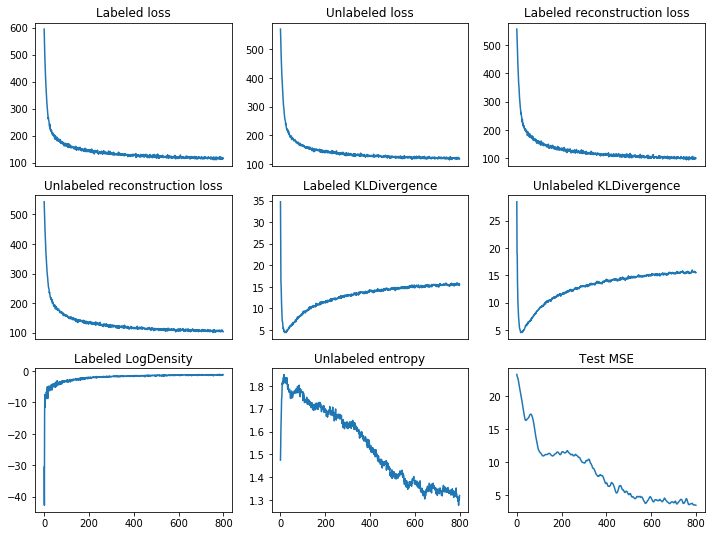

In [121]:
model.plotinfo()

In [ ]:
mu, sigma = model.predict(test_labeled[0])

# Compare this to logistic regression

In [16]:
import sklearn.linear_model as lm

In [17]:
model2 = lm.Ridge()

In [28]:
model2.fit(X[index[53000:54000]], np.argmax(Y[index[53000:54000]], axis=1))

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [29]:
pred = model2.predict(test_labeled[0])

In [30]:
np.mean(np.square(test_labeled[1]-pred))

5.618522543199898

# Compare to the same MLP

In [38]:
# Adapted from M2

class MLP():
    def __init__(self):
        # Reset all existing tensors
        tf.reset_default_graph()
        
        # Tracking data
        self.loss = {}
        self.record = {}
        
        # Define some parameters
        self.e = 0
        self.verbose = False
        
        # Define dimensionality
        self.input_dim = 784
        self.dims = [128, 64]
        self.prediction_dim = 1
        
        # Building the graph
        self.built = False
        self.sesh = tf.Session()
        self.ops = self.build()
        self.sesh.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter('logs', self.sesh.graph)
        
    def build(self):
        # Placeholders for input and dropout probs.
        if self.built:
            return -1
        else:
            self.built = True
            
        #####################
        # Building networks #
        #####################
        
        # Defining inputs
        x_in_labeled = tf.placeholder(tf.float32, shape=[None, self.input_dim], name="x_in_labeled")
        y = tf.placeholder(tf.float32, shape=[None, self.prediction_dim], name="y")
        
        # Building network q(y|x)
        pred = self.encoder(x_in_labeled,
                            output_dim=self.prediction_dim,
                            _is_train=True,
                            scope="regressor")
        
        
        #################
        # Defining loss #
        #################
        
        # Defining Loss for labeled data
        with tf.variable_scope("loss"):
            loss = tf.reduce_mean(tf.square(y-pred))
        
        ################
        # Optimization #
        ################
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            optim = tf.train.AdamOptimizer().minimize(loss)
            
        #########################
        # Network for later use #
        #########################
        x_ = tf.placeholder(tf.float32, shape=[None, self.input_dim], name="x")
        # Building network q(y|x)
        pred_= self.encoder(x_, output_dim=self.prediction_dim, _is_train=False, scope="regressor", reuse=True)
            
        return dict(
            x_in_labeled = x_in_labeled,
            y = y,
            x_ = x_,
            pred_ = pred_,
            optim = optim,
            loss = loss
        )
        
    ###########
    # Encoder #
    ###########
    def encoder(self, _input, _is_train, output_dim, _fn=tf.nn.relu, scope="encoder", reuse=None):
        with tf.variable_scope(scope, reuse=reuse):
            net = _input
            for dim in self.dims:
                net = tf.contrib.slim.fully_connected(net, dim, activation_fn=tf.identity)
                if self.verbose: print net
                net = tf.contrib.layers.batch_norm(net, is_training=_is_train)
                net = _fn(net)
            
            mu = tf.contrib.slim.fully_connected(net, output_dim, activation_fn=tf.identity)
            if self.verbose: print mu, log_sigma
            return mu
   
    ############
    # Training #
    ############
    def train(self, X_labeled, epochs, valid=None):
        e = 0
        start_e = self.e
        while e < epochs:
            for i in range(X_labeled.batch_num):
                
                # Get data
                x_labeled, y = X_labeled.next()
                
                # Training with labeled data
                feed_dict = {self.ops["x_in_labeled"]: x_labeled,
                             self.ops["y"]: y}
                ops_to_run = [self.ops["loss"],
                              self.ops["optim"]]
                loss, _ = self.sesh.run(ops_to_run, feed_dict)
                
                # Use Validation
                if valid != None:
                    pred = self.predict(valid[0])
                    mse = np.mean(np.square(valid[1]-pred[:, 0]))
                    
                
                if valid!=None:
                    sys.stdout.write("\rEpoch: [%2d/%2d] loss: %.2f, mse: %.2f"
                                     %(self.e, start_e+epochs, loss, mse))
                else:
                    sys.stdout.write("\rEpoch: [%2d/%2d] loss: %.2f"
                                     %(self.e, start_e+epochs, loss))

            self.e+=1
            e+= 1
            
    ##############
    # Prediction #
    ##############
    def predict(self, x=None):
        return self.sesh.run(self.ops["pred_"], {self.ops["x_"]: x})

In [40]:
model3 = MLP()

In [42]:
model3.train(train_labeled, 1000, valid=test_labeled)

Epoch: [1242/1243] loss: 0.02, mse: 2.06